# [Hw07] Multi-layer Neural Networks
Jeong Ji Hoon 2016010980

## Load Packages

In [1]:
import os
import struct
import numpy as np
import sys
import gzip
import matplotlib.pyplot as plt

# 1. Load the MNIST train and test data sets

In [2]:
# 수업 자료의 코드를 그대로 사용.

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels


# unzips mnist
if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

# 2. Set training & validation & test data

## 2-1. training & validation data

In [3]:
# 55000 개와 5000개로 traning set을 나눔.

X, y = load_mnist('', kind='train')

X_train = X[:55000,:]
y_train = y[:55000]
X_valid = X[55000:60000,:]
y_valid = y[55000:60000]

## 2-2. test data

In [4]:
X_test, y_test = load_mnist('', kind='t10k')
X_test = X_test[:10000,:]
y_test = y_test[:10000]

# 3. Evaluation

##  - Class Definition
- 수업 자료의 코드를 기반으로 수정.
- 수업 자료의 코드는 cost 의 경우 training set 에 대해서만, accuracy의 경우는 training set과  validations set에 대해서만 구함. 
- 이에 매 epoch 마다 validation set과 test set의 cost와 accuracy를 구할 수 있도록 변경함.

In [5]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """

    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid, X_test, y_test):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost_train': [], 'cost_valid': [], 'cost_test': [], 'train_acc': [], 'valid_acc': [], 'test_acc': []} ### editted ###

        y_train_enc = self._onehot(y_train, n_output)
        y_valid_enc = self._onehot(y_valid, n_output) ### added ###
        y_test_enc = self._onehot(y_test, n_output)  ### added ###

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                      1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h  # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out_train = self._forward(X_train)
            z_h, a_h, z_out, a_out_valid = self._forward(X_valid) ### added ###
            z_h, a_h, z_out, a_out_test = self._forward(X_test) ### added ###

            cost_train = self._compute_cost(y_enc=y_train_enc, output=a_out_train)
            cost_valid = self._compute_cost(y_enc=y_valid_enc, output=a_out_valid)
            cost_test = self._compute_cost(y_enc=y_test_enc, output=a_out_test) ### added ###

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            y_test_pred = self.predict(X_test) ### added ###

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])
            test_acc = ((np.sum(y_test == y_test_pred)).astype(np.float) /
                         X_test.shape[0])### added ###

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i + 1, self.epochs, cost_train,
                              train_acc * 100, valid_acc * 100))
            sys.stderr.flush()

            self.eval_['cost_train'].append(cost_train)
            self.eval_['cost_valid'].append(cost_valid)### added ###
            self.eval_['cost_test'].append(cost_test)### added ###
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            self.eval_['test_acc'].append(test_acc)### added ###

        return self



## 3-1. L2 regularization parameter

20/20 | Cost: 9017.85 | Train/Valid Acc.: 98.05%/97.24%  

0.0000 : 0.981 0.972 0.966


20/20 | Cost: 20737.43 | Train/Valid Acc.: 94.77%/96.14% 

0.1000 : 0.948 0.961 0.949


20/20 | Cost: 10181.01 | Train/Valid Acc.: 97.79%/97.44% 

0.0100 : 0.978 0.974 0.967


20/20 | Cost: 9144.34 | Train/Valid Acc.: 98.03%/97.24%  

0.0010 : 0.980 0.972 0.966


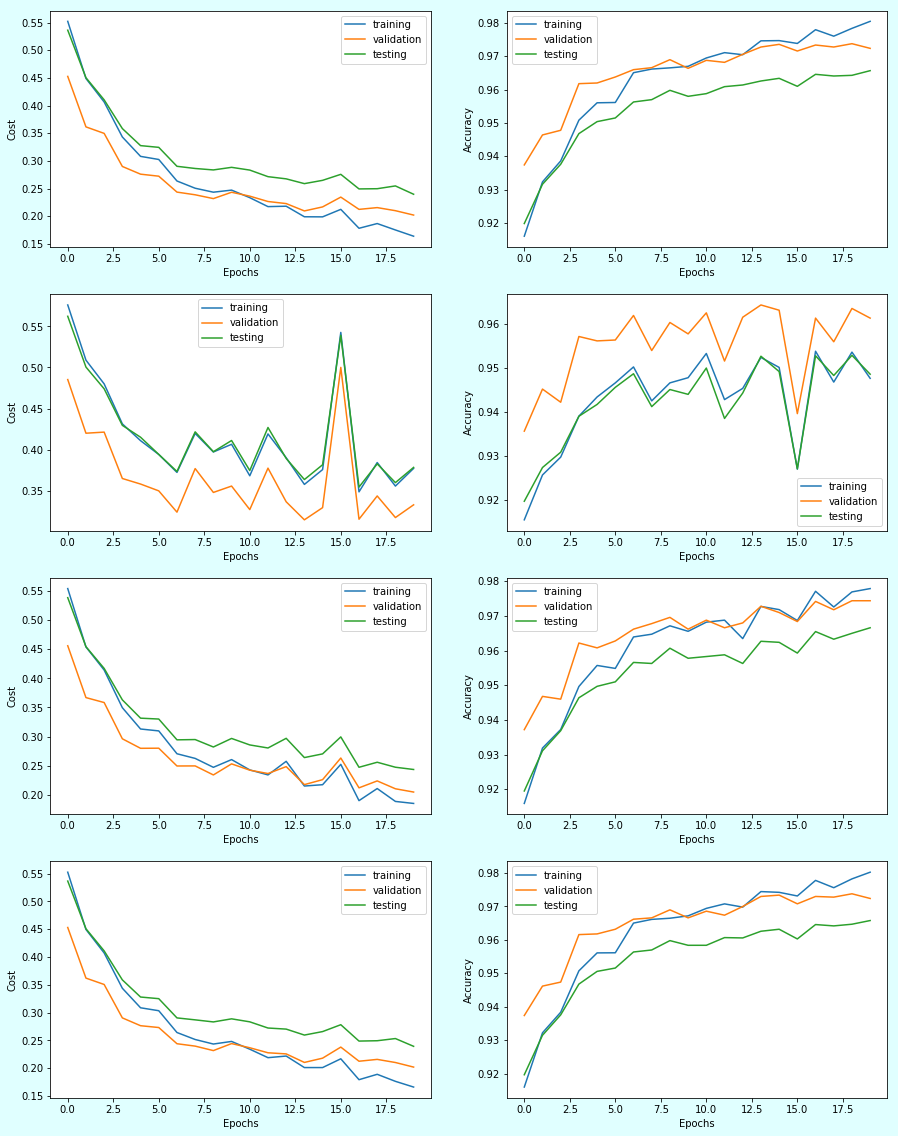

In [6]:
n_hidden = 50
n_epochs = 20
eta = 0.005
minibatch_size = 100
L2 = [0, 1e-1, 1e-2, 1e-3]

fig = plt.figure(figsize=(15,20))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(4,2)

for i, l in enumerate(L2):
    # make MLP
    nn = NeuralNetMLP(n_hidden=n_hidden,
                      l2=l,
                      epochs=n_epochs,
                      eta=eta,
                      minibatch_size=minibatch_size,
                      shuffle=True,
                      seed=1)
    # fit
    nn.fit(X_train=X_train,
       y_train=y_train,
       X_valid=X_valid,
       y_valid=y_valid,
       X_test=X_test,
       y_test = y_test)
    
    # draw plot    
    ax[i,0].plot(range(nn.epochs), np.array(nn.eval_['cost_train'])/np.shape(y_train)[0], label='training')
    ax[i,0].plot(range(nn.epochs), np.array(nn.eval_['cost_valid'])/np.shape(y_valid)[0], label='validation')
    ax[i,0].plot(range(nn.epochs), np.array(nn.eval_['cost_test'])/np.shape(y_test)[0], label='testing')
    ax[i,0].set_ylabel('Cost')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].legend()

    ax[i,1].plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
    ax[i,1].plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation')
    ax[i,1].plot(range(nn.epochs), nn.eval_['test_acc'], label='testing')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].legend()
    
    print("%.4f : %.3f %.3f %.3f" %(l, nn.eval_['train_acc'][-1], nn.eval_['valid_acc'][-1], nn.eval_['test_acc'][-1]))


### Observation
- cost의 경우 sample 수에 따라서 값의 크기가 달라지기에 plotting 할때 sample 수를 반영하여 그렸더니 각 집합별(training/validation/testing) cost 변화 추이를 확인할 수 있었다.
- 그럼에도 불구하고 현재 split 조건에서는 항상 validation 의 cost와 accuracy가 높게 나타났다. 
- 전반적으로 L2 regularization parameter와는 상관없이 90% 이상의 accruracy를 보였으나 그나마 1e-2 조건에서 결과가 가장 좋았다.

## 3-2. minibatch parameter

20/20 | Cost: 132185.23 | Train/Valid Acc.: 60.26%/62.60% 

1 : 0.603 0.626 0.610


20/20 | Cost: 49930.54 | Train/Valid Acc.: 87.61%/91.12% 

10 : 0.876 0.911 0.879


20/20 | Cost: 20737.43 | Train/Valid Acc.: 94.77%/96.14% 

100 : 0.948 0.961 0.949


20/20 | Cost: 531729.07 | Train/Valid Acc.: 9.94%/9.86% 0% 

1000 : 0.099 0.099 0.103


02/20 | Cost: 13482512.82 | Train/Valid Acc.: 11.29%/10.60% C:\Anaconda\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in multiply
20/20 | Cost: nan | Train/Valid Acc.: 9.74%/9.88% %/9.88% % 

10000 : 0.097 0.099 0.097


20/20 | Cost: 14269158.95 | Train/Valid Acc.: 11.29%/10.60% 

55000 : 0.113 0.106 0.114


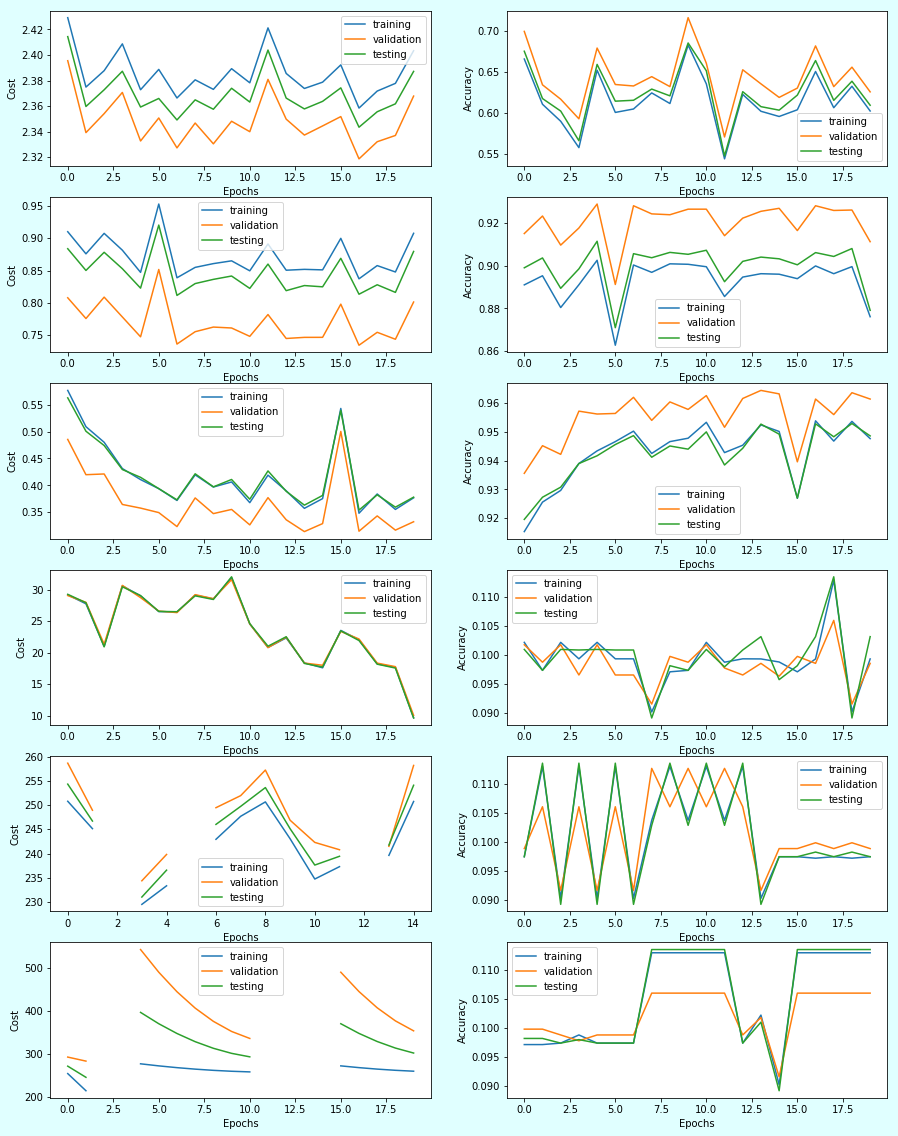

In [7]:
n_hidden = 50
n_epochs = 20
eta = 0.005
Minibatch_size = [1, 10, 100, 1000, 10000, 55000]
l2 = 1e-1

fig = plt.figure(figsize=(15,20))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(6,2)

for i, b in enumerate(Minibatch_size):
    # make MLP
    nn = NeuralNetMLP(n_hidden=n_hidden,
                      l2=l2,
                      epochs=n_epochs,
                      eta=eta,
                      minibatch_size=int(b),
                      shuffle=True,
                      seed=1)
    # fit
    nn.fit(X_train=X_train,
       y_train=y_train,
       X_valid=X_valid,
       y_valid=y_valid,
       X_test=X_test,
       y_test = y_test)
    
    # draw plot    
    ax[i,0].plot(range(nn.epochs), np.array(nn.eval_['cost_train'])/np.shape(y_train)[0], label='training')
    ax[i,0].plot(range(nn.epochs), np.array(nn.eval_['cost_valid'])/np.shape(y_valid)[0], label='validation')
    ax[i,0].plot(range(nn.epochs), np.array(nn.eval_['cost_test'])/np.shape(y_test)[0], label='testing')
    ax[i,0].set_ylabel('Cost')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].legend()

    ax[i,1].plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
    ax[i,1].plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation')
    ax[i,1].plot(range(nn.epochs), nn.eval_['test_acc'], label='testing')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].legend()
    
    print("%d : %.3f %.3f %.3f" %(b, nn.eval_['train_acc'][-1], nn.eval_['valid_acc'][-1], nn.eval_['test_acc'][-1]))


### Observation
- mini batch 크기에 따라 극명한 결과가 나타났다.
- size가 100인 경우에 가장 정확도가 높았고 1000 부터 정확도가 chance level로 떨어졌다. 
- 심지어 size가 10000이 넘는 경우 error 값이 너무 높아 코드 내부에서 연산 에러가 나오는 경우가 있었다. (그래프의 빈 부분들)

## 3-3. Misclassified Examples

20/20 | Cost: 9144.34 | Train/Valid Acc.: 98.03%/97.24%  

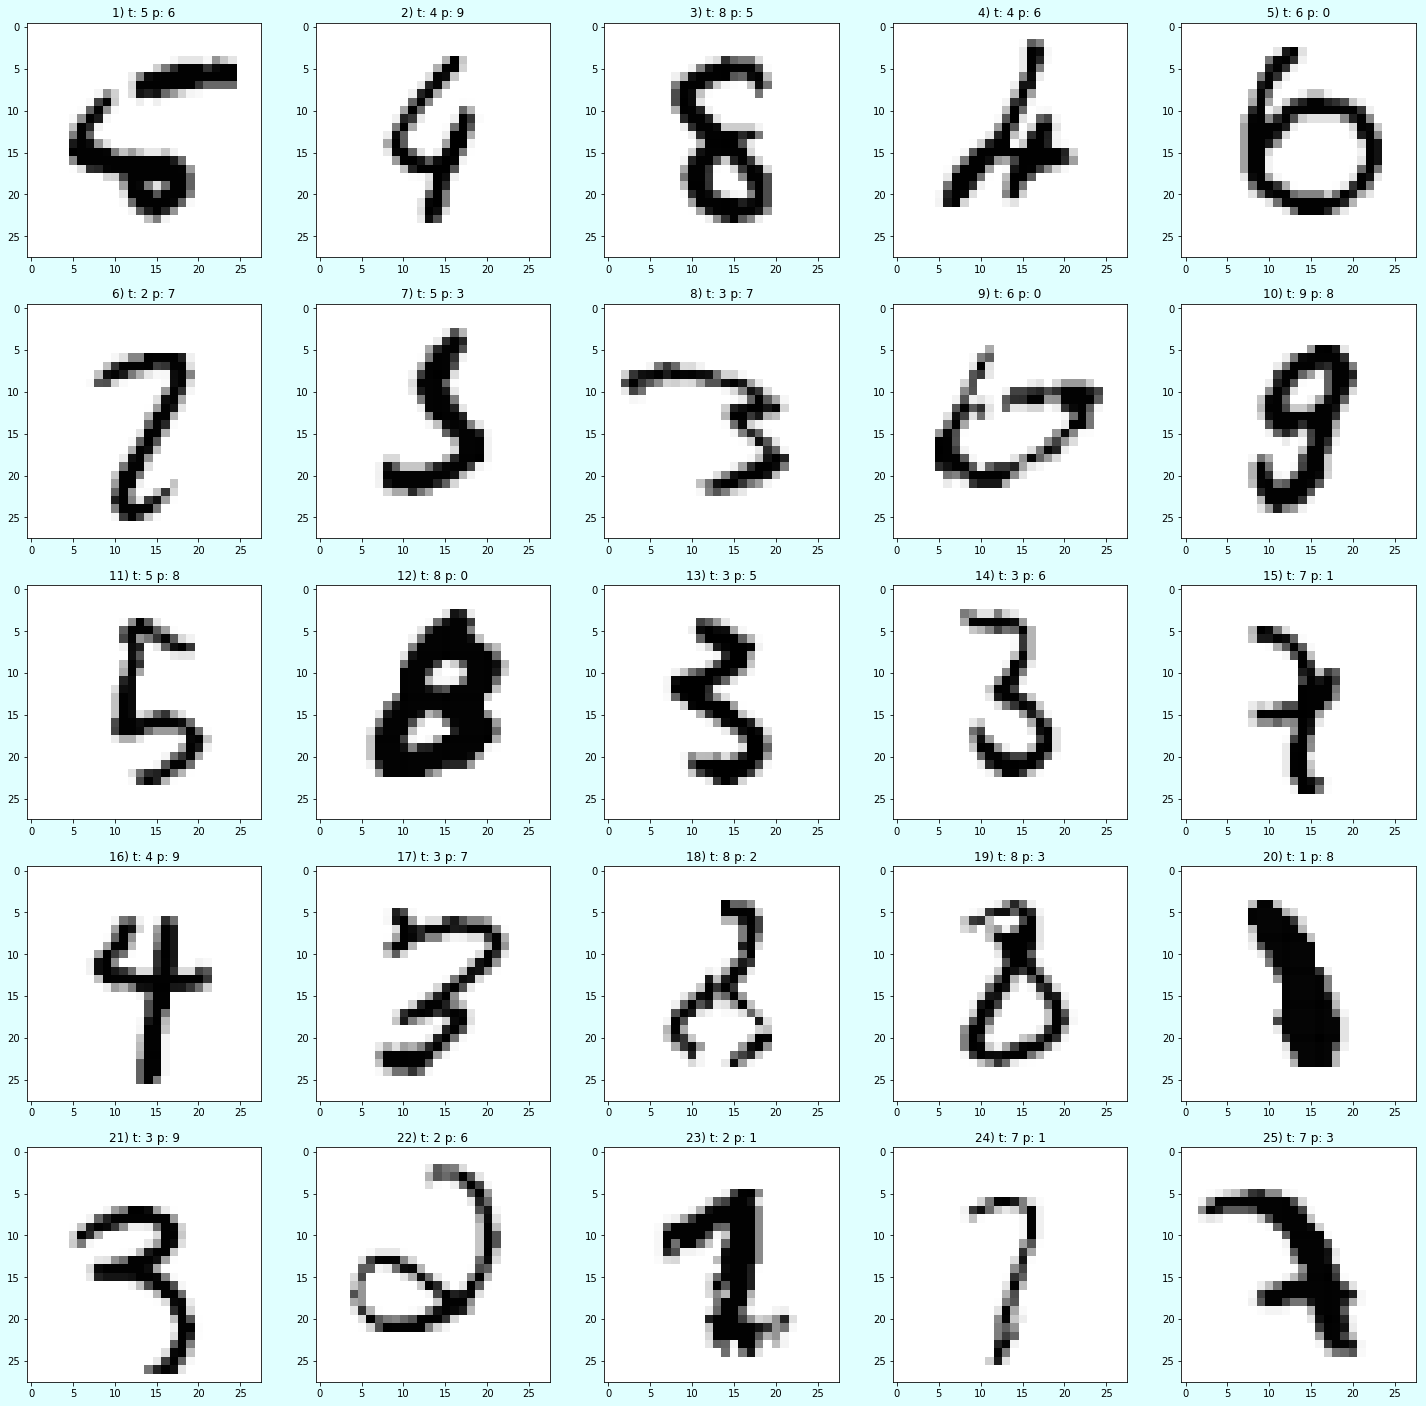

In [8]:
n_hidden = 50
n_epochs = 20
eta = 0.005
minibatch_size = 100
L2 = 0.01

fig = plt.figure(figsize=(25,25))
fig.patch.set_facecolor('lightcyan')

ax = fig.subplots(5,5)

# make MLP
nn = NeuralNetMLP(n_hidden=n_hidden,
                  l2=l,
                  epochs=n_epochs,
                  eta=eta,
                  minibatch_size=minibatch_size,
                  shuffle=True,
                  seed=1)
# fit
nn.fit(X_train=X_train,
   y_train=y_train,
   X_valid=X_valid,
   y_valid=y_valid,
   X_test=X_test,
   y_test = y_test)

y_test_pred = nn.predict(X_test)

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

# fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
# ax = ax.flatten()
for i in range(5):
    for j in range(5):
        img = miscl_img[5*i+j].reshape(28, 28)
        ax[i,j].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i,j].set_title('%d) t: %d p: %d' % (5*i+j+1, correct_lab[5*i+j], miscl_lab[5*i+j]))


### Observation
- 최종 classifier는 training set에 대해서 98%, validation set에 대해서 97% 의 정확도를 얻었다.
- test set을 가지고 잘못 classify 한 결과들을 확인한 결과 절반정도는 사람이 봐도 충분히 헷갈릴만한 형태였다. 
- 그러나 이전에 수업에서 봤던 example들을 생각해보면 training set에서 98% 정확도를 보이는 classifier의 수행치고는 조금 부족한 점이 보인다. (21번이라던가 16번은 대충봐도 4인데...)
- 이에 살짝 overfitting 된 결과가 아닐까 생각된다.